# QAOA 1D Ising Model Simulation 
## We use Qiskit's qasm simulator as the backend

In [2]:
import qiskit
import time
from matplotlib import pyplot as plt

In [3]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.10.0',
 'qiskit-aer': '0.3.2',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.3.3',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.13.0'}

In [4]:
from qiskit import IBMQ
import numpy as np

## Solving QAOA 1D ISING model n = 3,  p = 1 

Solving for $H = \sum_{j=1}^{n} J_j \sigma_j^z \sigma_{j+1}^z +  \sum_{j=1}^{n}h_j \sigma_j^x$, since we study the 1D Ising model, we set $h = 0$. Here we exexcute one iteration of the algorithm (p = 1) and choose two arbitrary $\gamma,\beta$ (I'm using two optimal values here though)


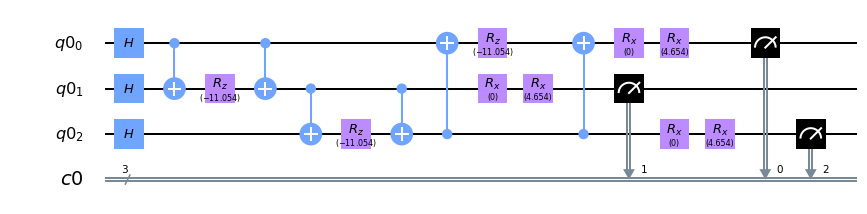

In [5]:
from qiskit import*
import numpy as np

n = 3


# normal sample for J's and h's
J = np.random.normal(0, 1, n)
hj = np.random.normal(0, 1, n)

for i in range(n):
    hj[i] = 0

# Set J
J = [-1,-1,-1]

# Angles
gamma = 5.527
beta = 2.327


qr = QuantumRegister(n)
cr = ClassicalRegister(n)

circuit = QuantumCircuit(qr, cr)

# Add a H gate on all qubits
for i in range(n):
    circuit.h(qr[i])
    
    
# apply U(gamma)
  
for i in range(n-1):
    circuit.cx(qr[i], qr[i+1])
    circuit.rz(2*gamma*J[i], qr[i+1])
    circuit.cx(qr[i], qr[i+1])
    
# last one n loops to n=0
circuit.cx(qr[n-1], qr[0])
circuit.rz(2*gamma*J[0], qr[0])
circuit.cx(qr[n-1], qr[0])

# apply U(beta)
for i in range(n):
    circuit.rx(2*gamma*hj[i],qr[i])
    circuit.rx(2*beta,qr[i])

circuit.measure(qr,cr)

circuit.draw(output='mpl')


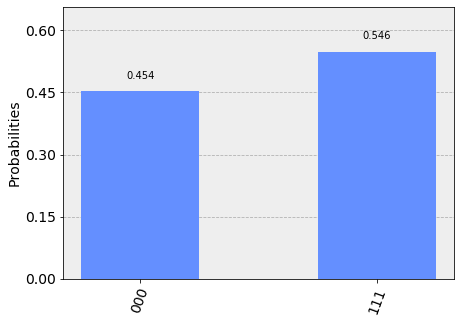

In [6]:
from qiskit.visualization import plot_histogram

# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

tot_counts = 1000

result = execute(circuit, simulator, shots=tot_counts).result()
counts = result.get_counts(circuit)
plot_histogram(counts)

## Methods for QAOA n = 3
Below is a function to get the counts in the standard basis (sometimes qiskit gives you a weird basis)

In [7]:
# Function to construct basis vectors
def basisF(bKey, bDict):
    
    p1, p2, p3 = bDict[bKey]
    
    if p1 == 1:
        v1 = [1,0]
    else:
        v1 = [0,1]
        
    if p2 == 1:
        v2 = [1,0]
    else:
        v2 = [0,1]
        
    if p3 == 1:
        v3 = [1,0]
    else:
        v3 = [0,1]
    
    return np.kron(np.kron(v1, v2), v3)

Calculating expectation for $H_{cost} = \sum_{j=1}^{n} J_j \sigma_j^z \sigma_{j+1}^z$ and $n=3$. Note that the expectation is calculated with the probability $P_n = \frac{counts(|n>)}{\sum_n counts(|n>)}$ so that the expectation is $E = P_n <n|H_{cost}|n>$, the latter term is calculated with the diagonal basis.

In [8]:
def exp_n3(counts,tot_counts, J):
    # Calculate the expectations for n = 3
    I = np.identity((2))
    X = [[0,1],[1,0]]
    Z = [[1,0],[0,-1]]
    z1 = np.kron(Z,np.kron(I,I))
    z2 = np.kron(I,np.kron(Z,I))
    z3 = np.kron(I,np.kron(I,Z))

    # Hc is diagonal
    Hc = J[0]*np.dot(z1,z2)+J[1]*np.dot(z2,z3)+J[2]*np.dot(z1,z3)
#     Hc = z3
    
    # Basis dict
    basisDict = {'000': [0,0,0], '010': [0,1,0], '001': [0,0,1], '101': [1,0,1], '110': [1,1,0], '100': [1,0,0], '011': [0,1,1], '111': [1,1,1]}
    
#     state = np.empty((2**n))
    cont = 0
    exptI = 0.0
    state = np.zeros((8,))
    for i in counts.keys():
#         state[cont] = (counts[i]/tot_counts)**1
        basisVec = basisF(i, basisDict)
        thisState = np.sqrt(counts[i]/tot_counts)*basisVec
        state = state + thisState
        exptI = exptI + (counts[i]/tot_counts)*np.matmul( np.transpose(basisVec), np.matmul(Hc, basisVec))
        cont = cont+1
    
#     print(exptI)
#     basisVec = basisF('110', basisDict)
#     print( np.matmul( np.transpose(basisVec), np.matmul(Hc, basisVec)) )
        
    # Compute expectation
    expt = np.matmul( np.transpose(state), np.matmul(Hc, state))

#     return np.sum(np.dot(Hc,state))
    return expt

# print(exp_n3(counts,tot_counts,J))

QAOA function that returns the counts given a number of sample angle pairs (depending on p):

In [9]:
# QAOA body 

def qaoa_counts(n, J, h, tot_counts, beta, gamma,p): 
    
    
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)

    circuit = QuantumCircuit(qr, cr)

    if (p == 1):
        
        # Add a H gate on all qubits
        for i in range(n):
            circuit.h(qr[i])

        # apply U(gamma)

        for i in range(n-1):
            circuit.cx(qr[i], qr[i+1])
            circuit.rz(2*gamma*J[i], qr[i+1])
            circuit.cx(qr[i], qr[i+1])

        # last one n loops to n=0
        circuit.cx(qr[n-1], qr[0])
        circuit.rz(2*gamma*J[0], qr[0])
        circuit.cx(qr[n-1], qr[0])

        # apply U(beta)
        for i in range(n):
#             circuit.rx(2*gamma*h[i],qr[i])
            circuit.rx(2*beta,qr[i])
    
    else: 
        
        # Add an H gate on all qubits (just once not every p)
        for i in range(n):
            circuit.h(qr[i])
        
        # apply U(gamma) and then U(beta) succesively 
        for k in range(p):

            # apply U(gamma)

            for i in range(n-1):
                circuit.cx(qr[i], qr[i+1])
                circuit.rz(2*gamma[k]*J[i], qr[i+1])
                circuit.cx(qr[i], qr[i+1])

            # last one n loops to n=0
            circuit.cx(qr[n-1], qr[0])
            circuit.rz(2*gamma[k]*J[0], qr[0])
            circuit.cx(qr[n-1], qr[0])

            
            # apply U(beta)
            for i in range(n):
#                 circuit.rx(2*gamma[k]*h[i],qr[i])
                circuit.rx(2*beta[k],qr[i])


    circuit.measure(qr,cr)

    simulator = Aer.get_backend('qasm_simulator')

    tot_counts = 1000

    result = execute(circuit, simulator, shots=tot_counts).result()
    counts = result.get_counts(circuit)


    return counts


Below is a function to study the p = 1, n = 3 case for both a random set of angles or a grid of angles 

In [10]:
# QAOA function for n = 3

def qaoa_n3(samples,anglesRandom,p,J):
    n = 3
    res = np.empty(samples) 
    
    if (p == 1):
        beta_res = np.empty((samples))
        gamma_res = np.empty((samples))
    else:
        beta_res = np.empty((samples,p))
        gamma_res = np.empty((samples,p))

    
    # number of shots to run
    tot_counts = 1000
    
    # normal sample for J's and h's 
    h = np.random.uniform(0, 1, n)

    for i in range(n):
#         J[i] = -1 
        h[i] = 0

    
    if (anglesRandom == False and p == 1):
        # step to make exactly samples number of samples
        # input samples should be a perfect square
        size_m = np.sqrt(samples)
        beta = np.linspace(0,np.pi/2, size_m)
        gamma = np.linspace(0,np.pi*2, size_m)
        
        for i in range(beta.shape[0]):
            for j in range(gamma.shape[0]):
                k = beta.shape[0]*i+j
                counts = qaoa_counts(n,J,h,tot_counts,beta[i],gamma[j],p)
                res[k] = exp_n3(counts,tot_counts,J)
                beta_res[k] = beta[i]
                gamma_res[k] = gamma[j]
       
    else:
        
        for k in range(samples):

            # beta from 0 to pi/2 due to periodicity considerations
            beta = np.random.uniform(0, np.pi/2, p)
            gamma = np.random.uniform(0, np.pi*2, p)
            
            counts = qaoa_counts(n,J,h,tot_counts, beta, gamma,p)
            res[k] = exp_n3(counts,tot_counts,J)
            
            if (p == 1):
                beta_res[k] = beta
                gamma_res[k] = gamma
            else: 
                beta_res[k,:] = beta
                gamma_res[k,:] = gamma

    
    return res,beta_res,gamma_res

## Testing
Below are some testing examples. First with random angles and performing the minimization using BFGS:

In [234]:
sT = time.time()
# for the number of samples please give a perfect square if using False
samples = 10000

res,beta_res,gamma_res = qaoa_n3(samples, True,1,[1,-0.25,0.25])


eT = time.time()
print('Elapsed time: ' + str(eT-sT))

Elapsed time: 270.75168895721436


In [251]:
imin = np.argmin(res)
print(res[imin]) 
print(beta_res[imin])
print(gamma_res[imin])

-1.0114999999999998
0.39661104925394913
3.1663509998016384


In [256]:
print(res[imin]) 

beta_first = beta_res[imin]
gamma_first = gamma_res[imin]

    
guesses = np.empty((2,p))
guesses[0,:] = beta_first
guesses[1,:] = gamma_first

mm = minimize(qaoa_expect,guesses, method='BFGS')

-1.0114999999999998


In [257]:
print(qaoa_expect(mm.x))

-1.0095


We test the angles grid:

In [372]:
# make contour plot on angles vs expectation

res,beta_res,gamma_res = qaoa_n3(5000, False,1,[1,-0.25,0.25])

In [218]:
imin = np.argmin(res)
print(res[imin]) 
print(beta_res[imin])
print(gamma_res[imin])

-1.0105
0.38468481472528077
3.2057067893773397


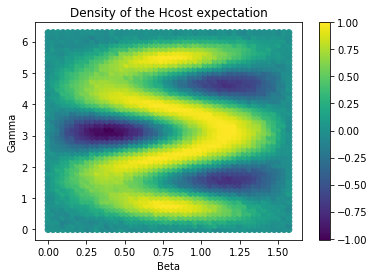

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.colorbar(ax.scatter(beta_res, gamma_res, c=res))
plt.xlabel("Beta")
plt.ylabel("Gamma")
plt.title('Density of the Hcost expectation')
plt.show()

Minimization procedure (with random angles), first choosing initial guesses by using 1000 samples and using the minimum value and then using BFGS:

In [11]:
# function to minimize
# J = [1,0.9,0.9]
J = [1,-0.25,0.25]
p = 1
def qaoa_expect(angles):
    beta = angles[:p]
    gamma = angles[p:]

    n,h,tot_counts = 3,[0,0,0],1000
    counts = qaoa_counts(n,J,h,tot_counts, beta, gamma,p)
    return exp_n3(counts,tot_counts,J)


In [12]:
from scipy.optimize import minimize

# Run 1000 samples, obtain first optimal min for beta gamma, then run again to obtain a better min
p = 1
# run with random angles
res,beta_res,gamma_res = qaoa_n3(1000, True,p,J)
imin_first = np.argmin(res)

if (p == 1):
    beta_first = beta_res[imin_first]
    gamma_first = gamma_res[imin_first]
else:
    beta_first = beta_res[imin_first,:]
    gamma_first = gamma_res[imin_first,:]
guesses = np.empty((2,p))
guesses[0,:] = beta_first
guesses[1,:] = gamma_first



In [13]:
# Optimize objective funciton with the first guesses
mm = minimize(qaoa_expect,guesses, method='BFGS')

In [14]:
print(qaoa_expect(mm.x))

-0.9955


Check QAOA accuracy with respect to lowest classical eigenvalue calculation. Fix $J_{12} = 1$ and make $J_{23},J_{13} \in [-1,1]$


In [15]:
# Classical n = 3
from numpy import linalg as LA

def minEig(J):

    I = np.identity((2))
    Z = [[1,0],[0,-1]]
    z1 = np.kron(Z,np.kron(I,I))
    z2 = np.kron(I,np.kron(Z,I))
    z3 = np.kron(I,np.kron(I,Z))

    zs = J[0]*np.dot(z1,z2)+J[1]*np.dot(z2,z3)+J[2]*np.dot(z1,z3)

    H = zs 
    e_val,e_vect = LA.eig(H)
    
    return np.min(e_val)

In [18]:
def opt_QAOA(J,p,samples):
    res,beta_res,gamma_res = qaoa_n3(samples, True,p,J)
    
    if (p == 1):
        imin_first = np.argmin(res)
        beta_first = beta_res[imin_first]
        gamma_first = gamma_res[imin_first]
        guesses = np.empty((2))
        guesses[0] = beta_first
        guesses[1] = gamma_first
    else:
        imin_first = np.argmin(res)
        beta_first = beta_res[imin_first,:]
        gamma_first = gamma_res[imin_first,:]
        guesses = np.empty((2*p))
        guesses[:p] = beta_first
        guesses[p:] = gamma_first
    
    def qaoa_expct(angles):
        beta = angles[:p]
        gamma = angles[p:]

        n,h,tot_counts = 3,[0,0,0],1000
        counts = qaoa_counts(n,J,h,tot_counts, beta, gamma,p)
        return exp_n3(counts,tot_counts,J)
    # Optimize objective funciton with the first guesses
    mm = minimize(qaoa_expct,guesses, method='BFGS')
    return qaoa_expct(mm.x)


In [19]:
# Use num_examples = 25, samples = 10 for a nice enough plot, takes about ~ 30 min 



num_examples = 5
j23 = np.linspace(-1,1,num_examples)
j13 = np.linspace(-1,1,num_examples)
j12 = np.ones(num_examples)

J13 = np.empty((num_examples**2)) 
J23 = np.empty((num_examples**2))


samples = 10  

delta_expcts = np.empty((num_examples**2))

for i in range(num_examples):
    for j in range(num_examples):
        k = num_examples*i+j
        J13[k] = j13[i]
        J23[k] = j23[j]

        J = [1,j23[j],j13[i]]
        ce = minEig(J)
        qe = opt_QAOA(J,1,samples)
        delta_expcts[k] = qe-ce
      

/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/martivives/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


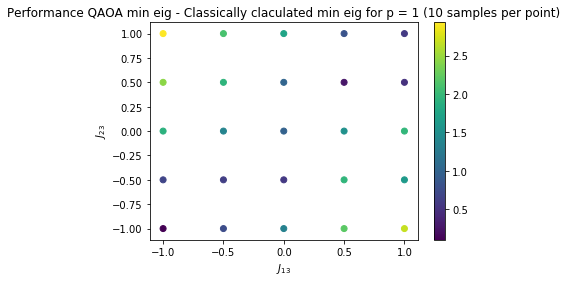

In [20]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.colorbar(ax.scatter(J13, J23, c=delta_expcts))
plt.xlabel("$J_{13}$")
plt.ylabel("$J_{23}$")
plt.title('Performance QAOA min eig - Classically claculated min eig for p = 1 (' + str(samples) + ' samples per point)')
plt.show()

We study QAOA as done classically by direct matrix multiplication

In [21]:
from scipy.linalg import expm

def QAOAn3_classically(J,gamma,beta):
    I = np.identity((2))
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])
    z1 = np.kron(Z,np.kron(I,I))
    z2 = np.kron(I,np.kron(Z,I))
    z3 = np.kron(I,np.kron(I,Z))
    
    H = [[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]]
    h1 = np.kron(H,np.kron(I,I))
    h2 = np.kron(I,np.kron(H,I))
    h3 = np.kron(I,np.kron(I,H))
    
    im = complex(0,1) # define the imaginary unit
    
    # initial state all zeros (s0 the 1,0,0,0,0,0,0,0)
    s_i = np.array([1,0,0,0,0,0,0,0])
    
    # Add a H gate on all qubits
    s = np.dot(h1,s_i)
    s = np.dot(h2,s)
    s = np.dot(h3,s)
        
    def rx(theta):
        return expm(-im*(theta/2)*X)
    
    rx1 = np.kron(rx(2*beta),np.kron(I,I))
    rx2 = np.kron(I,np.kron(rx(2*beta),I))
    rx3 = np.kron(I,np.kron(I,rx(2*beta)))
    
    Hc = J[0]*np.dot(z1,z2) + J[1]*np.dot(z2,z3) + J[2]*np.dot(z3,z1)
    H_mat = expm(-im*gamma*Hc)
    
    s = np.dot(H_mat,s)
    s = np.dot(rx1,s)
    s = np.dot(rx2,s)
    s = np.dot(rx3,s)

    return s
  

In [22]:
state_f = QAOAn3_classically([-1,-1,-1],5.52,2.32)

In [23]:
state_abs = np.abs(state_f)

In [24]:
print(state_abs)

[0.70689672 0.00995024 0.00995024 0.00995024 0.00995024 0.00995024
 0.00995024 0.70689672]


In [25]:
# J = [1,0.9,0.9] vs p

opt_QAOA([-1,-1,-1],1,20)

-2.9640000000000004

We study $p$ dependence here, note that random sampling is not an optimal procedure for $p>1$, explore Zhou et al. (2018)

<function matplotlib.pyplot.show(*args, **kw)>

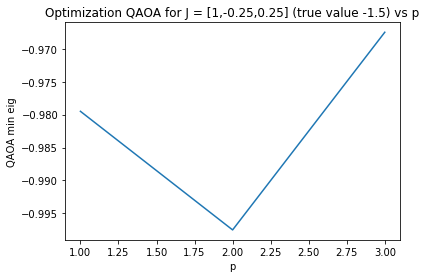

In [27]:
# set any desired max_p
max_p = 4
samples = 500
opts = []
ps = []
for i in range(1,max_p):
    ps.append(i)
    opts.append(opt_QAOA([1,-0.25,0.25],i,samples))
plt.plot(ps,opts)
plt.xlabel("p")
plt.ylabel("QAOA min eig")
plt.title("Optimization QAOA for J = [1,-0.25,0.25] (true value -1.5) vs p")
plt.show
